In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
cd /content/gdrive/My\ Drive/Public/

/content/gdrive/My Drive/Public


In [0]:
df = pd.read_csv('BBRI.JK.csv')

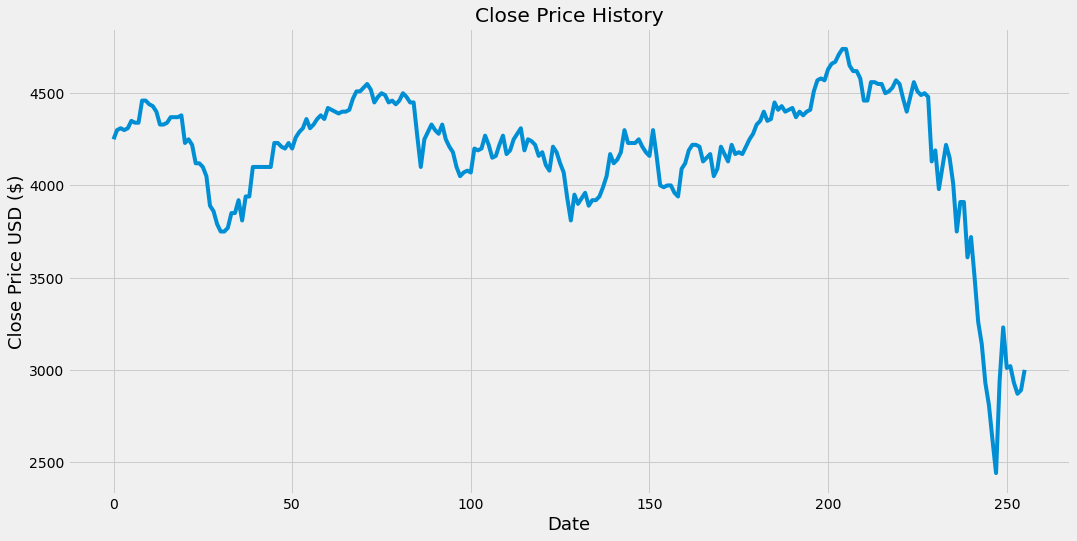

In [6]:
plt.figure(figsize=(16,8))
plt.title("Close Price History")
plt.plot(df['Close'])
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close Price USD ($)', fontsize = 18)
plt.show()

In [7]:
data = df.filter(['Close'])
dataset = data.values
training_data_len = math.ceil(len(dataset) * .8)

training_data_len

205

In [0]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [0]:
train_data = scaled_data[0:training_data_len,:]
x_train = []
y_train = []
for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i, 0])
  y_train.append(train_data[i, 0])

In [10]:
x_train, y_train = np.array(x_train) , np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(145, 60, 1)

In [11]:
#Build the LSTM model
model = keras.Sequential()
model.add(keras.layers.LSTM(64, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(keras.layers.LSTM(32, return_sequences=True))
model.add(keras.layers.LSTM(16, return_sequences=True))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(8))
model.add(keras.layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()
model.fit(x_train, y_train, batch_size = 1, epochs=30)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 64)            16896     
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 32)            12416     
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 16)            3136      
_________________________________________________________________
flatten (Flatten)            (None, 960)               0         
_________________________________________________________________
dense (Dense)                (None, 8)                 7688      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 40,145
Trainable params: 40,145
Non-trainable params: 0
____________________________________________________

In [12]:
test_data = scaled_data[training_data_len - 60:, :]
x_test =[]
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)) :
  x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

rmse = np.sqrt(np.mean(predictions-y_test)**2)
rmse

62.47755342371323

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


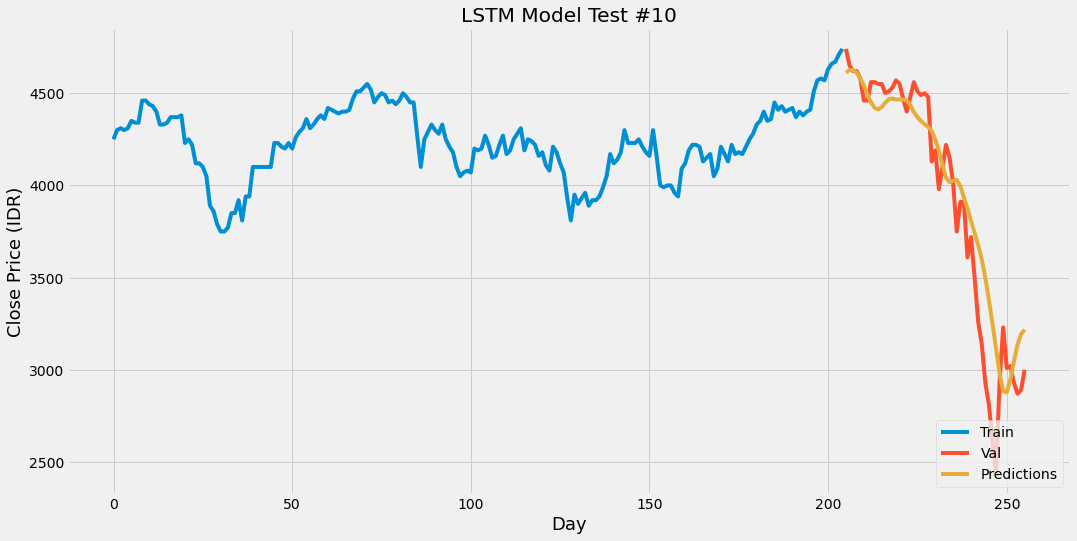

In [13]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title("LSTM Model Test #10")
plt.xlabel('Day', fontsize = 18)
plt.ylabel('Close Price (IDR)', fontsize = 18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()